In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# ENSEMBLE models

* to reduce bias and variance
* using different models as building block of the final mode => weak learners
* different models can have low bias and high variance or vice versa
* combining several weak learners into one model with better performance
* choice of the weak learners should be coherent with aggregation method

### BAGGING
* less variance than it's component
* parallel learning
* averaging process

### BOOSTING
* less bias than it's components 
* sequential learning, base model depends on the previous one

### STACKING
* less bias than it's components
* parallel learning 
* combination of output of weak learners is input into the metamodel

#### Reasons for using ensemble models
* small dataset
* non-linear complicated data

### Error(x) = Bias^2 + Variance + irreducible Error 
![variance vs bias](https://miro.medium.com/max/700/1*kISLC1Udq0m6g5kwHhMuJg@2x.png)

### DATA

In [2]:
# create the inputs and outputs
X, y = make_regression(n_samples=1000, n_features=100, noise=0.45)
# split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.40)
print('Train', X.shape, y.shape, 'Test', X_test.shape, y_test.shape)

Train (600, 100) (600,) Test (400, 100) (400,)


In [3]:
# muting some features to show variance bias dependency
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y)
lambdas = np.linspace(0, 100, 100)
bias = []
variance = []
for alpha in lambdas:
    
    # refit model with new λ hyperparameter
    beta = np.linalg.inv(df_X.T.dot(df_X) + np.diag([alpha] * len(df_X.T))).dot(df_X.T).dot(df_y).flatten()
    
    bias.append(np.mean(np.mean(np.abs(df_X.dot(beta) - df_y.values.flatten()))))
    variance.append(np.var(df_X.dot(beta)))
    
df_results = pd.DataFrame({'index': np.arange(1,len(bias)+1,1),'bias': bias, 'variance': variance})

<AxesSubplot:label='2e7ff3f5-40c2-481c-9aad-c226e388cc6e', xlabel='index', ylabel='variance'>

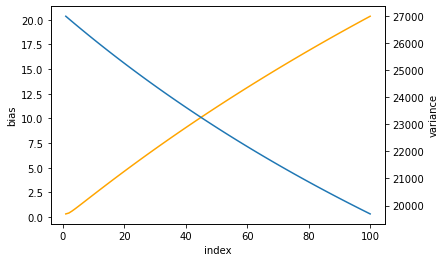

In [4]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(data=df_results, x='index', y='bias', color='orange' ,ax=ax)
sns.lineplot(data=df_results, x='index', y='variance', ax=ax2)

## Simple averaging ensemble model

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [6]:
# random seed to have control over our models
rand_seeds = np.arange(0,10,1)
n_models = 10
# lets fit 10 models
all_models = [RandomForestRegressor(random_state=rand_seeds[i]).fit(X, y) for i in range(n_models)]

In [7]:
single_scores = []
ensemble_scores = []

# get all predictions from all models
yhats_all = np.array([model.predict(X_test) for model in all_models])

# get scores for each of the model and different number of ensembles
for i in range(1, n_models+1):
    single_scores.append(np.sqrt(mean_squared_error(y_test, yhats_all[i-1])))
    ensemble_scores.append(np.sqrt(mean_squared_error(y_test, np.mean(yhats_all[:i+1], axis=0))))    
scores_all = np.sqrt(mean_squared_error(y_test, np.mean(yhats_all, axis=0)))


In [8]:
# let's look at the predicted data
for item in yhats_all:
    print('pred: ', item[:3])
print('true: ', y_test[:3])

pred:  [-89.90631248  60.77136079 132.6123417 ]
pred:  [-105.40151669   66.64053808  139.91524249]
pred:  [-81.32546091  56.4524501  148.28564596]
pred:  [-106.45201709   47.32016467  145.69551574]
pred:  [-81.6465797   63.64731223 140.15949602]
pred:  [-78.7078065   57.4569697  145.15963588]
pred:  [-67.21585192  36.95612091 122.20927376]
pred:  [-96.08879273  69.12964345 148.0908582 ]
pred:  [-102.36846148   75.34910335  148.80745105]
pred:  [-98.37488689  58.03095815 141.26075946]
true:  [-171.36984603  106.65516005   76.09986025]


Text(0.5, 1.0, 'ensemble')

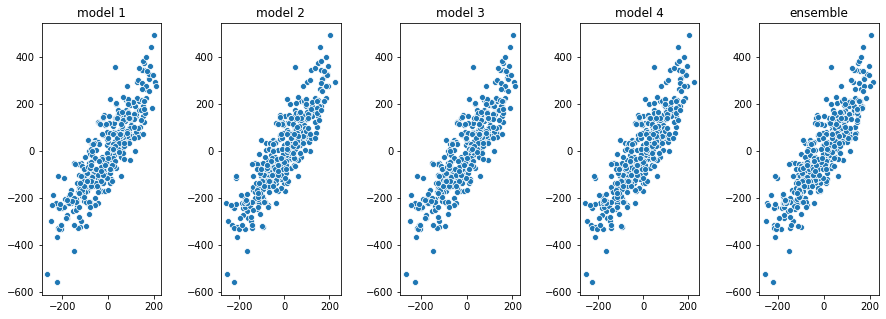

In [9]:
fig, axs = plt.subplots(ncols=5,figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(yhats_all[0], y_test, ax=axs[0]).set_title('model 1')
sns.scatterplot(yhats_all[1], y_test, ax=axs[1]).set_title('model 2')
sns.scatterplot(yhats_all[0], y_test, ax=axs[2]).set_title('model 3')
sns.scatterplot(yhats_all[1], y_test, ax=axs[3]).set_title('model 4')
sns.scatterplot(np.mean(yhats_all, axis=0), y_test.ravel(), ax=axs[4]).set_title('ensemble')

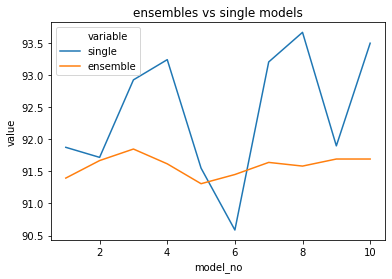

In [10]:
df_results = pd.DataFrame({'model_no': np.arange(1,11,1), 'single':single_scores, 'ensemble':ensemble_scores})
plot = sns.lineplot(x='model_no', y='value', hue='variable', 
             data=pd.melt(df_results, ['model_no'])).set_title('ensembles vs single models')

##  BAGGING

### Bootstraping
https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
https://towardsdatascience.com/bootstrapping-statistics-what-it-is-and-why-its-used-e2fa29577307
    
* random drawing N samples from the given dataset
* sampling with replacement
* dataset should be large enough to capture the complexity 
* size of N should be large enough compared to bootstrap dataset, so the samples are minimaly correlated

![bootstraping](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/Bagging.png)

* bootstrap samples are approximatively independet and with identical distribution 

1. generating N bootstrap sample sets from original dataset
2. each model is fitted using the one bootstrap sample set
3. than aggregating their predictions to get a model with lower variance

#### aggegregating
* reggression - averaging, weighted averaging if we have some other information
* classification 
1. hard voting - majority of votes
2. soft voting - probabilities of each class and returning the one with highest probability

* fitting of the models can be paralelised

### Random forest
* sampling not only over the observations in dataset but also over the features - keeping only the random subset of features
* feature subsets trick reduces correlation between outputs
* robust against missing data

![random forest](https://miro.medium.com/max/1000/1*_B5HX2whbTs3DS8M6YBD_w@2x.png)



* hyperparameter max_features=auto means n_features
* by default random forest is bagged ensemble tree model

![random forest](https://miro.medium.com/max/700/1*oFsapf7Jqs34Ov6LoIas6g.png)
* The impact of K, or max_features (x-axis), on Random Forest model error (y-axis) for 12 classification and 12 regression problems, as reported in P. Geurts, D. Ernst., and L. Wehenkel, “Extremely randomized trees”, Machine Learning, 63(1), 3–42, 2006. Notice that for classification problems, the optimal K is typically close to 1, but for regression problems (with the exception of Abalone), setting K equal to the original # of features yields the lowest error.

### Scikit bagging

In [11]:
X.shape, y.shape

((600, 100), (600,))

In [12]:
def print_rmse(model, X_test, y_test):
    yhats = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, yhats))
    print(rmse, ensemble_scores[-1])

In [13]:
from sklearn.ensemble import BaggingRegressor
model = BaggingRegressor(base_estimator=RandomForestRegressor(),
                         n_estimators=10, random_state=0).fit(X, y)

print_rmse(model, X_test, y_test)

97.8251696934507 91.69253331252494


In [14]:
from sklearn.svm import SVR
model = BaggingRegressor(base_estimator=SVR(),
                         n_estimators=10, random_state=0).fit(X, y)

print_rmse(model, X_test, y_test)

164.22127783914055 91.69253331252494


In [15]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
model = BaggingRegressor(base_estimator=neigh,
                         n_estimators=10, random_state=0).fit(X, y)

print_rmse(model, X_test, y_test)

145.08948428926962 91.69253331252494


In [17]:
from sklearn.neural_network import MLPRegressor

model = BaggingRegressor(base_estimator=MLPRegressor(max_iter=1500),
                         n_estimators=10, random_state=0).fit(X, y)

print_rmse(model, X_test, y_test)

59.91881976300885 91.69253331252494
